# Estimation of solar irradiance using ground-based whole sky imagers

## Few important points to note before running codes in this iPython notebook

### (a) Please check the format of the weather station data (might differ from the given format) <br />(b) Few files are pre-computed and used here directly (for ease of computation).

### Import all images for luminance computation

In [1]:
# Library to index all images in the directory.
import os
from glob import glob


# All file locations are stored here
global_files = []


# This is the complete path where our sky images are located. 
# <Please replace it with appropriate file location>
start_dir = '/media/soumya/SeagateBackupPlusDrive/sky_images/2015/12/' 


# Check for all JPG images in this path
pattern  = "*.jpg"
for direc,_,_ in os.walk(start_dir):
    global_files.extend(glob(os.path.join(direc,pattern)))
    

# Check for LDR image patterns in this list
pattern1  = "low.jpg"
pattern2  = "med.jpg"
pattern3  = "high.jpg"


# For final computation, we only select LDR images and low-exposure image (when captured in HDR mode)
files_low = []
files_single = []

for particular_file in global_files:
    if pattern1 in particular_file:
        files_low.append(particular_file)

    if (pattern1 not in particular_file) and (pattern2 not in particular_file) and (pattern3 not in particular_file):
        files_single.append(particular_file)

        
# The variable "selected_files" contains LDR images and low-exposure image (when captured in HDR mode)
selected_files = files_low
selected_files.extend(files_single)
selected_files = sorted(selected_files)

### Import all libraries

In [2]:
# Import all libraries

import sys
sys.path.insert(0, './helperScripts/')

import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import exifread
import pytz
from matplotlib.dates import DateFormatter


# User defined functions
from normalize_array import *
from CalculateLuminance import *  
from sun_positions_day_files import *
from import_WS import *
from import_WS_CI import *
from nearest import *
from SG_solarmodel import *

### Find unique dates in the list of images

In [3]:
date_list = []

for i,_ in enumerate(selected_files):
    image_path = selected_files[i]
    path_components = image_path.split("/")
    image_name = path_components[len(path_components)-1]
    image_date = image_name[0:10] 
    date_list.append(image_date)

unik_dates = list(set(date_list))
unik_dates = sorted(unik_dates)
unik_dates = ['2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17', '2015-12-18', '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25']

print ('Unique dates are ', unik_dates)

print ('The missing dates are because of the outage of the sky camera')

Unique dates are  ['2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17', '2015-12-18', '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25']
The missing dates are because of the outage of the sky camera


In [4]:
CSV_file = './weatherData/Dec2015.csv'
(daterange,datetime_range,solar_range,clearsky_range,clearnessindex_range,rainfall_range) = import_WS_CI(CSV_file)
(time_range,solar_range) = import_WS(CSV_file)

### Indexing a particular date from datetime objects

In [5]:
date_strings = [dt.strftime("%Y-%m-%d") for dt in daterange]
oneFineDate = unik_dates[6]
print (oneFineDate)

findPosition = np.where(np.array(date_strings)==oneFineDate)
findPosition = findPosition[0]

2015-12-07


### Observation for a sample day

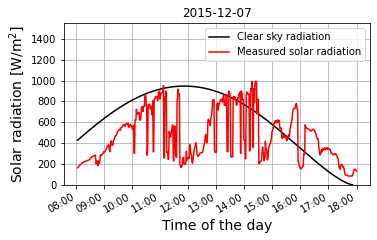

In [7]:
day_datetime = list(datetime_range[i] for i in findPosition )
day_clearnessindex = list( clearnessindex_range[i] for i in findPosition )
day_rain = list( rainfall_range[i] for i in findPosition )
day_solarrad = list( solar_range[i] for i in findPosition )    
day_CSR = list( clearsky_range[i] for i in findPosition )


# Difference solar radiation
day_diffindex = [1-x for x in day_clearnessindex]
match_string = str(oneFineDate)

TZ = pytz.timezone('Asia/Calcutta')
# We consider from 7:00 Hours to 20:00 Hours
start_time = datetime.datetime(2015,12,7,7,0,0, tzinfo=TZ)
end_time = datetime.datetime(2015,12,7,20,0,0, tzinfo=TZ)


measSolar = []
csSolar = []
timeXAxis = []
for i,item in enumerate(day_datetime):
    if item > start_time and item<end_time:
        measSolar.append(float(day_solarrad[i]))
        csSolar.append(day_CSR[i])
        sw = datetime.datetime(item.year,item.month,item.day,item.hour,item.minute,item.second)
        timeXAxis.append(sw)
        
measSolar = np.array(measSolar)
csSolar = np.array(csSolar)
        

figure_number = 1 
fig = plt.figure(figure_number , figsize=(5.5, 3.3))
plt.plot(timeXAxis, csSolar, 'k' , label='Clear sky radiation') 
plt.plot(timeXAxis, measSolar, 'r' , label='Measured solar radiation') 
plt.xlabel('Time of the day', fontsize=14)
plt.ylabel(r'Solar radiation [W/m$^2$]', fontsize=14)  
plt.title(match_string)
plt.legend(loc='upper right')
plt.grid(b=None, which='major', axis='both')
plt.ylim((0,1550))
fig.autofmt_xdate()
formatter = DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter) 
plt.savefig('./outputFiles/Figure1.pdf', format='pdf')


### Computes the luminance of all the images at different time-stamps consecutively. 

We consider the dimension of the cropped image as 300 X 300 (more details on this *optimum* crop size later in this notebook). This cropped image is considered around the circum-solar region. All images between 7 hours and 19 hours are considered.

In some cases, the sun is obscured from view because of the clouds. We neglect those days from computation.

### *Following section is already pre-computed and the results are saved in the repository *

In [8]:
# We consider 300 X 300 for optimal result.
crop_dim = 300


# Combined file name
comb_file_name = './preComputed/combined/Dec2015' +'.txt'
comb_text_file = open(comb_file_name, "w")
comb_text_file.write("Sl_No, Date, Time, Sun-X, Sun-Y, Luminance \n")  
    
    
    
# Estimating luminance from images
for dt,date_now in enumerate(unik_dates):
    

    print ('--------------------------------------------')
    # Found is the list of files for a single day
    found = []
    for particular_file in selected_files:
        if date_now in particular_file:
            found.append(particular_file)
            
    

    # And now calculating for a single Day
    # Extracting information from the string
    YY = date_now[0:4]
    MON = date_now[5:7]
    DD = date_now[8:10]    
    sYY = str(YY)
    sMON = str(MON)
    sDD = str(DD)
    if len(MON)==1:
        sMON = str(0)+MON
    if len(DD)==1:
        sDD = str(0)+DD
    match_string = sYY + '-' + sMON + '-' + sDD
    print ('Computing for ',match_string)
    
    

    # The output "select_images" contain those images between 7 hours and 19 hours.
    (sun_x_list, sun_y_list,select_images) = sun_positions_day_files(YY,MON,DD,found)
    
    
    # In case, sun is obscured throughout the day, we neglect that particular day.
    if (len(sun_x_list)==0 or len(sun_y_list)==0):
        print ('Skipping for ',match_string, ' because sun could not be located.')
        print ('Luminance .TXT file not generated.')
        continue
        
        
        
    # We generate individual .TXT files comprising the luminance values of images at different hours of a single day.
    file_name = './preComputed/calculatedLuminanceFiles/luminance-' + match_string +'.txt'
    text_file = open(file_name, "w")
    

    # Header line of generated .TXT file.
    text_file.write("Sl_No, Date, Time, Sun-X, Sun-Y, Luminance \n")     


    # Calculation of luminance for all images in a single day.
    for i,low_LDR_path in enumerate(select_images):

        sun_x = sun_x_list[i]
        sun_y = sun_y_list[i]
        LDR_path = low_LDR_path
        (date,time,LDRLuminance) = LuminanceSquareCrop(LDR_path,sun_x,sun_y,crop_dim)
        text_file.write("%s,%s,%s,%s,%s,%s\n" %(i,date,time,sun_x,sun_y,LDRLuminance))        
        
        
        # Writing in the combined text file
        comb_text_file.write("%s,%s,%s,%s,%s,%s\n" %(i,date,time,sun_x,sun_y,LDRLuminance))


    text_file.close() 
    print ('Calculating luminance completed for ',match_string)
    
    
print ('All file are generated')    
comb_text_file.close() 

--------------------------------------------
Computing for  2015-12-01
Number of images added between 7 am and 7 pm =  0
Skipping for  2015-12-01  because sun could not be located.
Luminance .TXT file not generated.
--------------------------------------------
Computing for  2015-12-02
Number of images added between 7 am and 7 pm =  0
Skipping for  2015-12-02  because sun could not be located.
Luminance .TXT file not generated.
--------------------------------------------
Computing for  2015-12-03
Number of images added between 7 am and 7 pm =  0
Skipping for  2015-12-03  because sun could not be located.
Luminance .TXT file not generated.
--------------------------------------------
Computing for  2015-12-04
Number of images added between 7 am and 7 pm =  0
Skipping for  2015-12-04  because sun could not be located.
Luminance .TXT file not generated.
--------------------------------------------
Computing for  2015-12-05
Number of images added between 7 am and 7 pm =  0
Skipping for  2

### Listing all the luminance .TXT files 

In [10]:
import os
from glob import glob
start_dir = './preComputed/calculatedLuminanceFiles/' # December
dirs = os.listdir( start_dir)

luminance_files = []
for text_file in dirs:
    if '.txt' in text_file:
        luminance_files.append(text_file)

luminance_files = sorted(luminance_files)        
print (luminance_files)

['luminance-2015-12-02.txt', 'luminance-2015-12-03.txt', 'luminance-2015-12-04.txt', 'luminance-2015-12-05.txt', 'luminance-2015-12-06.txt', 'luminance-2015-12-07.txt', 'luminance-2015-12-08.txt', 'luminance-2015-12-09.txt', 'luminance-2015-12-10.txt', 'luminance-2015-12-11.txt', 'luminance-2015-12-12.txt', 'luminance-2015-12-13.txt', 'luminance-2015-12-19.txt']


### Correlation for individual days of the month.

---------------------------------
Computing correlation for  2015-12-2
Correlation =  0.9308612230384166
---------------------------------
Computing correlation for  2015-12-3
Correlation =  0.8540782333508247
---------------------------------
Computing correlation for  2015-12-4
Correlation =  0.886133046132143
---------------------------------
Computing correlation for  2015-12-5
Correlation =  0.9064235039466005
---------------------------------
Computing correlation for  2015-12-6
Correlation =  0.9230321570980545
---------------------------------
Computing correlation for  2015-12-7
Correlation =  0.7291479553528628
---------------------------------
Computing correlation for  2015-12-8
Correlation =  0.9241630791219907
---------------------------------
Computing correlation for  2015-12-9
Correlation =  0.8468530729594632
---------------------------------
Computing correlation for  2015-12-10
Correlation =  0.930066707203049
---------------------------------
Computing correlation 

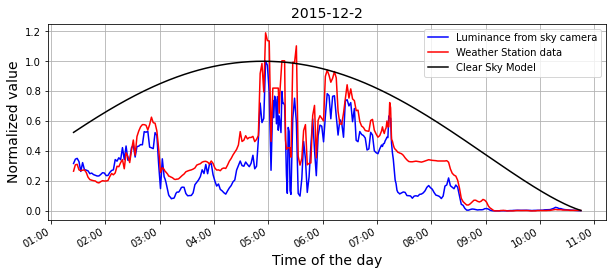

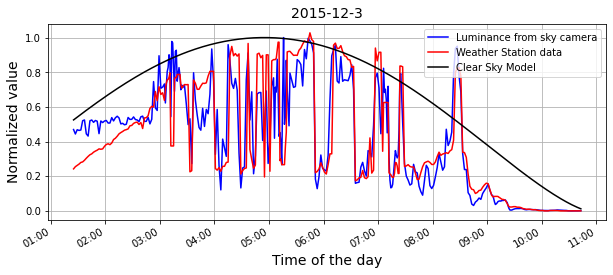

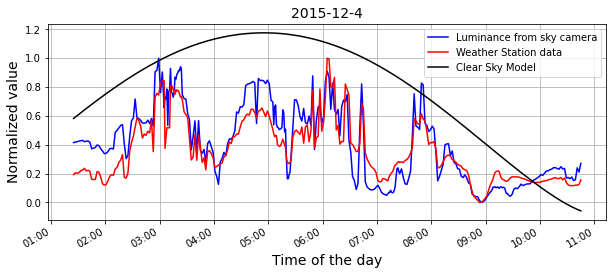

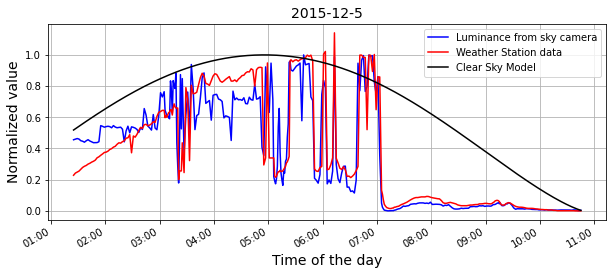

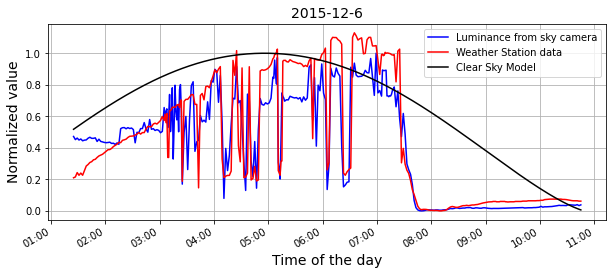

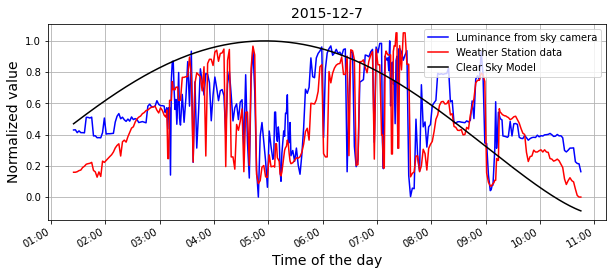

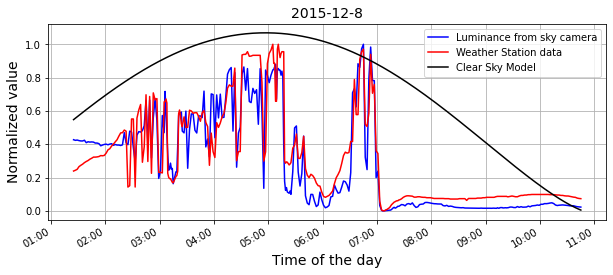

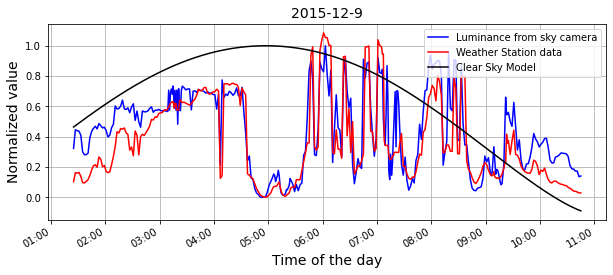

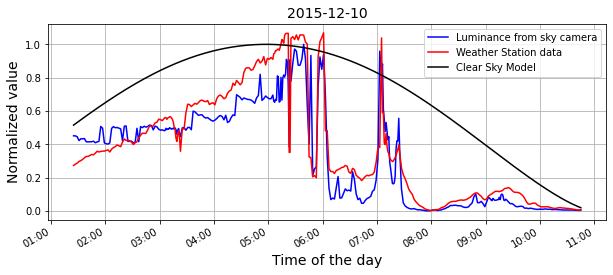

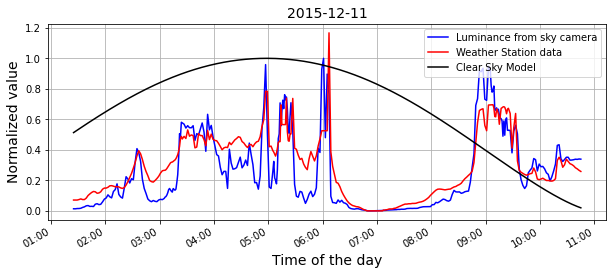

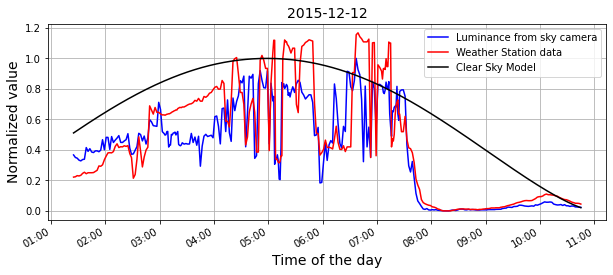

In [12]:
comb_file_name = './preComputed/combined/Dec2015.txt'
comb_file = open(comb_file_name, "w")
comb_file.write("Date, Time, Luminance, SolarRadiation, ClearSkyRadiation \n") 

figure_number = 0

Luminance_array = []
Solar_array = []
Luminance_array_OV = []
Solar_array_OV = []


for graph_number, lumi_file in enumerate(luminance_files):
    
    print ('---------------------------------')
    
    
    # ### Read the LDR generated data
    lumi_file = start_dir + lumi_file

    
    # read the finalised HDR file
    with open(lumi_file) as f: #f is a file header
        reader = csv.reader(f, delimiter=",")
        d = list(reader) # d is a list of list here.
        total_rows = len(d)

    img_date = []
    img_time = []
    img_luminance = np.zeros(total_rows-1)
    
    # variable i starts from 1 so that header is skipped
    for i in range(1,total_rows):
        date_item = d[i][1]
        time_item = d[i][2]
        unitylumi_item = d[i][5]
        img_date.append(date_item)
        img_time.append(time_item)
        img_luminance[i-1] = unitylumi_item



    # This is for plotting dates in X-axis
    time_datapoints = []

    TZ = pytz.timezone('Asia/Singapore')

    for i in range(0,len(img_date)):
        YY = int(img_date[i][0:4])
        MON = int(img_date[i][5:7])
        DD = int(img_date[i][8:10])
        HH = int(img_time[i][0:2])
        MM = int(img_time[i][3:5])
        SS = int(img_time[i][6:8])

        sw = datetime.datetime(YY,MON,DD,HH,MM,SS,tzinfo=TZ)
        time_datapoints.append(sw)

   
    match_string = str(YY) + '-' + str(MON) + '-' + str(DD)
    print ('Computing correlation for ',match_string)
    
    
    # Pick the Weather Station data corresponding to image
    WS_timestamp = time_range
    WS_solar_rad = solar_range
    image_timestamp = time_datapoints
    

    common_timestamps = []
    WS_datapoints = []
    img_datapoints = []
    

    # Check wrt to image datapoints.
    for i,check_time in enumerate(image_timestamp):
    
        (time_found,diff_ts) = nearest(check_time,WS_timestamp)
        #print ('Check time is ',check_time,'and found time is ',time_found, 'Difference = ' , diff_ts)
    
        if np.abs(diff_ts)<10:
        
            common_timestamps.append(check_time)
            img_datapoints.append(img_luminance[i])
        
            # Check the corresponding index of WS data
            i2 = WS_timestamp.index(time_found)
            WS_datapoints.append(WS_solar_rad[i2])


    if len(WS_datapoints)<50:
        print ('Not enough weather station datapoints to perform computation')
        print ('Correlation not computed for ',match_string)
        continue


    WS_dtp = np.zeros(len(WS_datapoints))
    for i,qaz in enumerate(WS_datapoints):
        WS_dtp[i] = float(qaz)    
    
   
    
    # Calculate the clear sky radiation
    latitude = 1.3429943
    longitude = 103.6810899
    clear_sky_rad = []
    for date_part in common_timestamps:

        CSR = SG_model(date_part)
        clear_sky_rad.append(CSR)
        
    clear_sky_rad = np.array(clear_sky_rad)
    
    MaxClearSky = np.max(clear_sky_rad[10:-10])
    MinClearSky = np.min(clear_sky_rad[10:-10])
    MinWS = np.min(WS_dtp[10:-10])
    MaxWS = np.max(WS_dtp[10:-10])
    MinSolar = np.min([MaxClearSky , MinWS])
    MaxSolar = np.min([MaxClearSky , MaxWS])
    
    
   
    img_datapoints = np.asarray(img_datapoints)
    WS_dtp = np.asarray(WS_dtp)   
    

    x_vect = normalize_array(img_datapoints[10:-10])
    y_vect = normalize_array(WS_dtp[10:-10])
    z_vect = normalize_array(clear_sky_rad[10:-10])
    time_vect = common_timestamps[10:-10]
    
    
    x_vectORG = img_datapoints[10:-10]
    y_vectORG = WS_dtp[10:-10]
    z_vectORG = clear_sky_rad[10:-10]
    
    
    # Different normalization technique
    normCSR = normalize_arrayWRT(clear_sky_rad[10:-10] , MinSolar, MaxSolar)
    normLuminance = normalize_array(img_datapoints[10:-10])
    normWS = normalize_arrayWRT(WS_dtp[10:-10], MinSolar , MaxSolar) 
    
    
    # Current normalization technique
    # Done wrt to clear sky model
    figure_number = figure_number + 1
    fig = plt.figure(figure_number , figsize=(10, 4))
    plt.plot(time_vect, normLuminance, 'b', label='Luminance from sky camera')
    plt.plot(time_vect, normWS, 'r', label='Weather Station data')
    plt.plot(time_vect, normCSR, 'k', label='Clear Sky Model')
    plt.xlabel('Time of the day', fontsize=14)
    plt.ylabel('Normalized value', fontsize=14)
    plt.title(match_string, fontsize=14)
    plt.legend(loc='upper right')
    fig.autofmt_xdate()
    plt.grid(b=None, which='major', axis='both')
    formatter = DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
    #plt.savefig('./outputFiles/Figure3.pdf', format='pdf')
    
    
    # Update the text file
    for i , onetime in enumerate(time_vect):
        YearHere = onetime.year
        MonthHere = onetime.month
        DayHere = onetime.day
        
        YY = str(YY)
        MON = str(MON)
        DD = str(DD)
        if len(MON)==1:
            MON = str(0)+MON
        if len(DD)==1:
            DD = str(0)+DD
        date_string = YY + '-' + MON + '-' + DD
        
        HourHere = onetime.hour
        MinHere = onetime.minute
        SecHere = onetime.second
        HH = str(HourHere)
        MINT = str(MinHere)
        SEC = str(SecHere)        
        if len(HH)==1:
            HH = str(0)+HH
        if len(MINT)==1:
            MINT = str(0)+MINT
        if len(SEC)==1:
            SEC = str(0)+SEC            
        time_string = HH + '-' + MINT + '-' + SEC        
        
        
        comb_file.write("%s,%s,%s,%s,%s\n" %(date_string, time_string, x_vectORG[i] , y_vectORG[i] , z_vectORG[i]))
    
    
    r = np.corrcoef(normLuminance, normWS)
    print ('Correlation = ', r[0][1])
    
    
    
    # Append the data for scatter plot later
    Luminance_array.append(normLuminance)
    Solar_array.append(normWS)    
    Luminance_array_OV.append(x_vectORG)
    Solar_array_OV.append(y_vectORG)
    
    
comb_file.close()     

## Combined correlation for entire month

Correlation =  0.9308612230384166


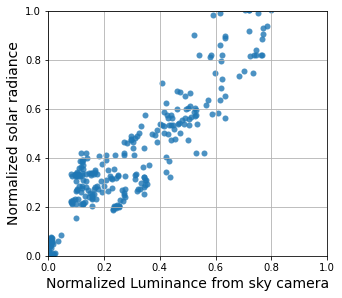

In [13]:
# Combined array needed for computation

Luminance_array = np.array(Luminance_array)
LA = Luminance_array[0]

Solar_array = np.array(Solar_array)
SA = Solar_array[0]


Luminance_array_OV = np.array(Luminance_array_OV)
LA_OV = Luminance_array_OV[0]
Solar_array_OV = np.array(Solar_array_OV)
SA_OV = Solar_array_OV[0]


# Scatter plot for luminance & Solar Radiation
plt.figure(10,figsize=(5, 4.5))
plt.scatter(LA, SA, marker='o' , linewidths=0.01 , alpha = 0.8)
plt.xlabel('Normalized Luminance from sky camera', fontsize=14)
plt.ylabel('Normalized solar radiance', fontsize=14)
plt.grid(b=None, which='major', axis='both')
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig('./outputFiles/Figure5.pdf', format='pdf')
r = np.corrcoef(LA, SA)
print ('Correlation = ', r[0][1])

### Finding optimum crop dimension

In [14]:
import os
from glob import glob
from findSelectedFiles import *

# This is the complete path where our sky images are located. 
# <Please replace it with appropriate file location>
start_dir = '/media/soumya/SeagateBackupPlusDrive/sky_images/2015/12/03/' #

selected_files = findSelectedFiles(start_dir)

### We calculate the optimum crop dimension based on a sample day

In [28]:
# ### Finding unique dates in the folder

date_list = []
for i,_ in enumerate(selected_files):
    image_path = selected_files[i]
    path_components = image_path.split("/")
    image_name = path_components[len(path_components)-1]
    image_date = image_name[0:10] 
    date_list.append(image_date)

unik_dates = list(set(date_list))
unik_dates = sorted(unik_dates)
print ('Unique dates are ', unik_dates)

Unique dates are  []


### Iterating for various crop dimensions

### *Following section is already pre-computed and the results are saved in the repository *

In [29]:
from findCorrelation import *

file_name = './preComputed/sampleDayData/03Dec2015.txt'
CropSizeImpact = open(file_name, "w")
CropSizeImpact.write("Crop_Dimension, Corelation \n") 

crop_array = np.array(range(100,1250,50))


for crop_dim in crop_array:

    # ### Estimating LDR luminance for all dates (Main Execution)
    for dt,date_now in enumerate(unik_dates):
        print ('---------------------------------')
        r = findCorrelation(crop_dim,dt,date_now,selected_files,unik_dates,time_range,solar_range)
        print ('Correlation = ', r)
        CropSizeImpact.write("%s,%s\n" %(crop_dim,r))

CropSizeImpact.close()     

### Crop size graph 

In [30]:
crop_array = np.array(range(100,1250,50))
with open('./preComputed/sampleDayData/03Dec2015.txt') as f: #f is a file header
    reader = csv.reader(f, delimiter=",")
    d = list(reader) # d is a list of list here.

    
CropSize = []
CorrVal = []
for item in d[1:]:
    CropSize.append(item[0])
    CorrVal.append(item[1])


SizeVector = np.zeros(len(CropSize)) 
CorrVector = np.zeros(len(CorrVal))  

for i,value in enumerate(CropSize):
    SizeVector[i] = int(value)

for i,value in enumerate(CorrVal):
    CorrVector[i] = float(value)

SizeVector = SizeVector[0:14]
CorrVector = CorrVector[0:14]


plt.figure(1) 
width = .5
ind = np.arange(len(CorrVector))
barlist = plt.bar(ind, CorrVector, width, label='Correlation', alpha=0.85)
barlist[np.argmax(CorrVector)].set_color('r')
plt.xticks(ind + width/2, crop_array)
#plt.title('Impact of image crop-size on correlation', fontsize=14)
plt.xlabel('Length of cropped square image', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.ylim((0.7,0.9))
plt.xlim([0,ind.size])
plt.grid(b=None, which='major', axis='both')
plt.legend(loc='upper right')
plt.savefig('./outputFiles/Figure4.pdf', format='pdf')

ValueError: attempt to get argmax of an empty sequence